# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».


В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Откройте и изучите файл

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')

df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Согласно предоставленной информации, каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

В предоставленном датасете отсутсвуют пропущенные значения в виду проведенной ранее предобработке в предыдущем проекте. Стандартно проверим датасет на наличие дубликатов.

In [4]:
df.duplicated().sum()

0

Явные дубликаты остутствуют. 
Посмотрим общее описание датасета

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Учитывая, что данная задачу к типу классификация (предложение пользоватеям наиболее подходящего тарифа), то в качестве целевого признака (который будем предсказывать) будем использовать столбец is_ultra.

Проверим на сбалансированность столбец is_ultra.

0    2229
1     985
Name: is_ultra, dtype: int64


<Axes: >

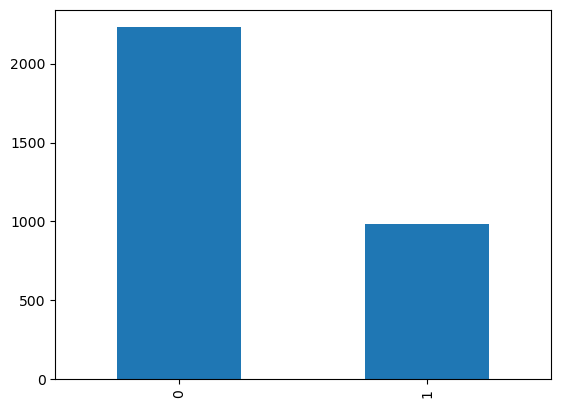

In [6]:
m_lines_frequency = df['is_ultra'].value_counts()
print(m_lines_frequency)
m_lines_frequency.plot(kind='bar')

Следуюем отметить, что выборка не является сбалансированной. Данный фактор необходимо учитывать при дальнейшем обучении моделей.

## Разбейте данные на выборки

Перед проработкой вопроса по выбору наиболее подходящей модели предложения тарифа разобьем текущий датасет на 3 выбоки: обущающую, валидационную и тестовую. Перед этим обозначим целевой и остальные признаки.

In [7]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra'] #целевой признак

#разбиваем иходную выборку на 2: тренировочную и рабочую.
df_train, df_work = train_test_split(df, test_size=0.4, random_state=12345)

#разбиваем рабочую выборку на валидационную и тестовую
df_valid, df_test = train_test_split(df_work, test_size=0.4, random_state=12345)

Теперь мы имеем 3 выборки с целевыми и остальными признаками:
1) df_train -  тренировочная выборка для обучения модели (60% от всей выборки)

2) df_valid - валидационная выборка для предварительной проверки моделей (20% от всей выборки)

3) df_test - тестовая выборка, по которой будем оценивать модель финально. (20% от всей выборки)

## Исследуйте модели

Для дальнейшей подготовки и иследования моделей, создадим переменные с целевыми и остальными признаками для ранее подговотоленных выборок

In [8]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']


Учитывая, что это задача классификации, рассмотрим 3 основные модели:

- Дерево решений
- Случайный лес
- Логистическую регрессию

**Дерево решений**

На начальном этапе рассмотрим базовую модель дерева решений без учета глубины.

In [9]:
model_basic_tree = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_basic_tree.fit(features_train, target_train)

train_pred_basic_tree = model_basic_tree.predict(features_train)

valid_pred_basic_tree = model_basic_tree.predict(features_valid)

print("Accuracy")
print("Обучающая выборка:", accuracy_score(target_train, train_pred_basic_tree))
print("Валидационная выборка:", accuracy_score(target_valid, valid_pred_basic_tree))

Accuracy
Обучающая выборка: 1.0
Валидационная выборка: 0.7198443579766537


Обучающаяя выборка дает почти 100% точность, при этом валидационная выборка дает точность порядка 70%. 30% большая разница, поэтому подберем для данной модели параметр глубины дерева.

Учитывая, что признаков (бех целевого) в датасете всего 4, то произведем перебор глубины деревьев от 1 до 4 и выберем наиболее подходящий параметр.

In [10]:
best_model_dt = None
best_result_dt = 0
for depth in range(1, 4):
    model_depth_tree = DecisionTreeClassifier(random_state=12345, max_depth= depth, class_weight='balanced') 
    model_depth_tree.fit(features_train, target_train) 
    predictions = model_depth_tree.predict(features_valid) 
    result = accuracy_score(target_valid, predictions) 
    if result > best_result_dt:
        best_model_dt = model_basic_tree
        best_result_dt = result
        
print("Accuracy лучшей модели:", best_result_dt,'глубина:', depth)

Accuracy лучшей модели: 0.7846952010376135 глубина: 3


При увеличении грубины дерева до 3, точность исследования повысилась на 9,2%. Разрыв между тренировочной и валидационной выборкой сократился. Сохраним модель.

In [11]:
model_depth_tree = DecisionTreeClassifier(random_state=12345, max_depth= 3, class_weight='balanced') 
model_depth_tree.fit(features_train, target_train)

train_pred_depth = model_depth_tree.predict(features_train)

valid_pred_depth = model_depth_tree.predict(features_valid)

print("Accuracy")
print("Обучающая выборка:", accuracy_score(target_train, train_pred_depth))
print("Валидационная выборка:", accuracy_score(target_valid, valid_pred_depth))

Accuracy
Обучающая выборка: 0.8054979253112033
Валидационная выборка: 0.7808041504539559


Следует отметить, что теперь точность на тренировочной выборке снизилась, при этом на валидационной выборке повысилась.

**Случайный лес**

Примениим модель случайного леса. Остается определить подходящее количество деревьев. На превой итерации возьмем от 1 до 10.

In [12]:
best_model_rf_v0 = None
best_result_v0 = 0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=12345, n_estimators= est, class_weight='balanced') 
    model.fit(features_train, target_train) 
    result = model.score(features_valid, target_valid) 
    if result > best_result_v0:
        best_model_v0 = model
        best_result_v0 = result

print("Accuracy наилучшей модели на валидационной выборке:", best_result_v0, 'количество деревьев:', est)

Accuracy наилучшей модели на валидационной выборке: 0.7769130998702983 количество деревьев: 10


На данном этапе видно, что при максимальном количестве деревьев, точность 78%. Попробуем увеличить перебор количества деревьев до 50. Также произведе перебор глубины деревьев от 1 до 4.

In [13]:
%%time
best_model_v1 = None
best_result_v1 = 0
best_depth_v1 = 0
for est in range(1, 51, 10):
    for depth in range(1,4):
        model = RandomForestClassifier(random_state=12345, n_estimators= est, max_depth = depth, class_weight='balanced') 
        model.fit(features_train, target_train) 
        result = model.score(features_valid, target_valid) 
        if result > best_result_v1:
            best_model_v1 = model
            best_result_v1 = result
            best_depth_v1 = depth

print("Accuracy наилучшей модели на валидационной выборке:", best_result_v1, 'количество деревьев:', est, 'глубина:', depth )

Accuracy наилучшей модели на валидационной выборке: 0.788586251621271 количество деревьев: 41 глубина: 3
CPU times: user 416 ms, sys: 2.94 ms, total: 418 ms
Wall time: 417 ms


Точность повысилась  при увеличении количества деревьев до 41 и глубины 3. В данном случае остановимся на количестве деревьев в количестве 41.

Сохраним модель для дальнейшего тестирования.

In [14]:
model_rand_for = RandomForestClassifier(random_state=12345, n_estimators= 41, max_depth =3, class_weight='balanced') 
model_rand_for.fit(features_train, target_train)

train_pred_rand = model_rand_for.predict(features_train)

valid_pred_rand = model_rand_for.predict(features_valid)

print("Accuracy")
print("Обучающая выборка:", accuracy_score(target_train, train_pred_rand))
print("Валидационная выборка:", accuracy_score(target_valid, valid_pred_rand))

Accuracy
Обучающая выборка: 0.8065352697095436
Валидационная выборка: 0.7821011673151751


Увеличение количества деревьев также приводит к повышению точности на валидационной выборке.

**Логистическая регрессия**

Рассмотрим модель логистической регресси.

In [15]:
model_log_regr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model_log_regr.fit(features, target)

train_pred_log = model_log_regr.predict(features_train)
valid_pred_log = model_log_regr.predict(features_valid)

print("Accuracy")
print("Обучающая выборка:", accuracy_score(target_train, train_pred_log))
print("Валидационная выборка:", accuracy_score(target_valid, valid_pred_log))

Accuracy
Обучающая выборка: 0.7474066390041494
Валидационная выборка: 0.7613488975356679


Точность предсказания на логистической регресси 76%. При этом снизилась точность для обучающей выборки.
Попробуем изменить параметр max_iter до 10000 и посмотреть, как изменится точность.

In [16]:
model_log_regr_v2 = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=10000) 
model_log_regr_v2.fit(features, target)

train_pred_log_v2 = model_log_regr_v2.predict(features_train)
valid_pred_log_v2 = model_log_regr_v2.predict(features_valid)

print("Accuracy")
print("Обучающая выборка:", accuracy_score(target_train, train_pred_log_v2))
print("Валидационная выборка:", accuracy_score(target_valid, valid_pred_log_v2))

Accuracy
Обучающая выборка: 0.7474066390041494
Валидационная выборка: 0.7613488975356679


Глобально картина не изменилась. Попробуем заменить параметр solver и использовать liblinear.

In [17]:
model_log_regr_v2 = LogisticRegression(random_state=12345, solver='liblinear', max_iter=10000) 
model_log_regr_v2.fit(features, target)

train_pred_log_v2 = model_log_regr_v2.predict(features_train)
valid_pred_log_v2 = model_log_regr_v2.predict(features_valid)

print("Accuracy")
print("Обучающая выборка:", accuracy_score(target_train, train_pred_log_v2))
print("Валидационная выборка:", accuracy_score(target_valid, valid_pred_log_v2))

Accuracy
Обучающая выборка: 0.7411825726141079
Валидационная выборка: 0.7587548638132295


Точность немного снизилась на валидационной выборке. На данном этапе оставим алгоритм lbfgs и max_iter = 1000.

**Вывод - лучшая по точности модель**

Самая высокая точность на валидационной выборке у модели случайный лес в параметрами n_estimators= 41, max_depth =3, class_weight='balanced'.
Далее ее будем использовать для проверки тестовой выборки. 

## Проверьте модель на тестовой выборке

Выбранную лучшей по точности модель проверим на тестовой выборке.

In [18]:
test_pred_depth = model_rand_for.predict(features_test)


print("Accuracy")
print("Тестовая выборка:", accuracy_score(target_test, test_pred_depth))

Accuracy
Тестовая выборка: 0.7922330097087379


## Проверка модели на адекватность

В качестве проверки моделей на адекватность, возьмем за основу DummyClassifier

In [20]:
from sklearn.dummy import DummyClassifier

d_model = DummyClassifier(strategy='prior', random_state=12345)
d_model.fit(features_train, target_train)

d_train_pred = d_model.predict(features_train)
d_valid_pred = d_model.predict(features_valid)
d_test_pred = d_model.predict(features_test)

print('Accuracy')
print('Тренировочная выборка:',d_model.score(features_train, target_train))
print('Валидационная выборка:',d_model.score(features_valid, target_valid))
print('Тестовая выборка:',d_model.score(features_test, target_test))

Accuracy
Тренировочная выборка: 0.6924273858921162
Валидационная выборка: 0.7029831387808041
Тестовая выборка: 0.683495145631068


Точность в данном случае ниже по сравнению с моделью случайного леса.

## Вывод

На основании проведенных исследований лучше всего показывают себя модели Дерево решений с глубиной 3 и Лес Деревьев. 

Глубина дерева влияет на точность предсказаний. В данном случае, чем больше глубина (до определенного значения) тем выше точность.

Точность модели Случайный лес достигает 79%.